In [1]:
!pip install ../../gentrain/.

Processing /Users/benkraling/code/thesis/gentrain
  Preparing metadata (setup.py) ... done
  Created wheel for gentrain: filename=gentrain-0.1.2-py3-none-any.whl size=27325 sha256=0488cacf56d29aa1d8ac6d6f8b25d434bf9984002c31406e2c0edaa44d0eadb8
  Stored in directory: /private/var/folders/2h/923cq6912sqb0snfvqqfdnmm0000gn/T/pip-ephem-wheel-cache-6gbot5pz/wheels/cf/e4/57/91c03db2e8c043adeefe35dd0969d3049f61ae0218be0acc9f
Successfully built gentrain
  Attempting uninstall: gentrain
    Found existing installation: gentrain 0.1.2
    Uninstalling gentrain-0.1.2:
      Successfully uninstalled gentrain-0.1.2


In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
from sklearn.metrics import adjusted_rand_score
import numpy as np
from gentrain.evaluation import candidate_evaluation_and_matrices, get_candidate_evaluation_and_export_mst, get_infection_detection_scores, get_lineage_purity
from gentrain.encoding import get_nucleotide_sensitive_encodings, get_mutation_sensitive_encodings, generate_one_hot_encoding
from gentrain.nextclade import get_mutations_from_dataframe
from gentrain.candidate_sourcing import bitwise_xor_candidates
from gentrain.graph import build_mst, export_graph_gexf, mean_edge_weight, get_outbreak_community_labels, build_graph
from gentrain.distance_matrix import get_bitwise_xor_distance_matrix, get_kendall_tau_correlation, get_infection_recall, get_infection_precision, get_infection_f1, get_signed_rmse, get_signed_infection_rmse
import os
import shutil
import plotly.express as px

In [3]:
import plotly.io as pio
pio.renderers.default = "png"

In [4]:
aggregate = "nrw_2022"
size = 1250

In [5]:
graph_path = f"graphs/{aggregate}/{size}"
if os.path.exists(f"graphs/{aggregate}/{size}") and os.path.isdir(f"graphs/{aggregate}/{size}"):
    shutil.rmtree(f"graphs/{aggregate}/{size}")
if not os.path.exists(f"graphs/{aggregate}"):
    os.mkdir(f"graphs/{aggregate}")
os.mkdir(f"graphs/{aggregate}/{size}")

In [6]:
sequences_df = pd.read_csv(f"../00_data_understanding_and_preparation/aggregates/{aggregate}/{size}/sequences_and_metadata.csv", delimiter=";").set_index("igs_id").sort_index()
sequences_count = len(sequences_df)

In [7]:
mutations_df = get_mutations_from_dataframe(sequences_df)

In [8]:
distance_matrix_df = pd.read_csv(f"../01_algorithm_optimization/distance_matrices/{aggregate}/{size}/distance_matrix.csv", delimiter=";",
                                     index_col="Unnamed: 0").sort_index()
distance_matrix_df = distance_matrix_df[~distance_matrix_df.index.duplicated(keep='first')]
distance_matrix_df = distance_matrix_df.loc[sequences_df.index, sequences_df.index]
distance_matrix = distance_matrix_df.to_numpy()

In [9]:
gentrain_graph = build_graph(distance_matrix)
gentrain_mst = build_mst(gentrain_graph)
gentrain_community_labels = get_outbreak_community_labels(gentrain_mst)
datetime_sampling_dates = pd.to_datetime(sequences_df["date_of_sampling"])
numeric_dates = (datetime_sampling_dates - datetime_sampling_dates.min()).dt.days
export_graph_gexf(gentrain_mst, gentrain_community_labels, sequences_df, f"{graph_path}/gentrain")

mst generation time: 1.79s


In [10]:
from collections import Counter
np.median(distance_matrix), mean_edge_weight(gentrain_mst), len(Counter(gentrain_community_labels))

(np.float64(26.0), np.float64(4.298478783026419), 58)

In [11]:
mask = np.triu(np.ones(distance_matrix_df.shape), k=1).astype(bool)
filtered = distance_matrix_df.where(mask)
infections_count = (filtered < 2).sum().sum()
distances_count = filtered.count().sum()

In [12]:
encodings_no_filter = get_mutation_sensitive_encodings(sequences_df, exclude_indels=False, use_frequency_filtering=False, filter_N=False)
encodings_N_frequency_filtering = get_mutation_sensitive_encodings(sequences_df, exclude_indels=False, use_frequency_filtering=False, filter_N=True)
encodings_N_and_SNV_frequency_filtering = get_mutation_sensitive_encodings(sequences_df, exclude_indels=False, use_frequency_filtering=True, filter_N=True)

execution time: 24.95s
execution time: 25.28s
execution time: 25.35s


In [13]:
evaluation = []

In [14]:
observed_matrix = get_bitwise_xor_distance_matrix(encodings_no_filter)
observed_graph = build_graph(observed_matrix)
observed_mst = build_mst(observed_graph)
observed_community_labels = get_outbreak_community_labels(observed_mst)
lineage_purity = get_lineage_purity(list(sequences_df["clade"]), observed_community_labels)
export_graph_gexf(observed_mst, gentrain_community_labels, sequences_df, f"{graph_path}/no_filter")

evaluation.append({
    "label": "No Filter",
    "correlation": get_kendall_tau_correlation(distance_matrix, observed_matrix), 
    "signed_rmse": get_signed_rmse(distance_matrix, observed_matrix), 
    "signed_infection_rmse": get_signed_infection_rmse(distance_matrix, observed_matrix), 
    "infection_recall": get_infection_recall(distance_matrix, observed_matrix), 
    "infection_precision": get_infection_precision(distance_matrix, observed_matrix), 
    "infection_f1": get_infection_f1(distance_matrix, observed_matrix), 
    "median_distance": np.median(observed_matrix),
    "community_count_diff": len(Counter(observed_community_labels))-len(Counter(gentrain_community_labels)),
    "adjusted_rand_index": adjusted_rand_score(gentrain_community_labels, observed_community_labels),
    "mean_edge_weight": mean_edge_weight(observed_mst),
    "lineage_purity": lineage_purity,
    "encoding_length": len(encodings_no_filter[0])
})
mean_edge_weight(observed_mst)-mean_edge_weight(gentrain_mst),lineage_purity-get_lineage_purity(list(sequences_df["clade"]), gentrain_community_labels)

matrix generation time: 1.86s
mst generation time: 2.5s


/Users/benkraling/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/community/community_louvain.py:487: RuntimeWarning:

overflow encountered in scalar negative



(np.float64(4.058847077662132), np.float64(-0.02639999999999998))

In [15]:
observed_matrix = get_bitwise_xor_distance_matrix(encodings_N_frequency_filtering)
observed_graph = build_graph(observed_matrix)
observed_mst = build_mst(observed_graph)
observed_community_labels = get_outbreak_community_labels(observed_mst)
lineage_purity = get_lineage_purity(list(sequences_df["clade"]), observed_community_labels)
export_graph_gexf(observed_mst, gentrain_community_labels, sequences_df, f"{graph_path}/N_frequency_filtering")

evaluation.append({
    "label": "N Filter",
    "correlation": get_kendall_tau_correlation(distance_matrix, observed_matrix), 
    "signed_rmse": get_signed_rmse(distance_matrix, observed_matrix), 
    "signed_infection_rmse": get_signed_infection_rmse(distance_matrix, observed_matrix), 
    "infection_recall": get_infection_recall(distance_matrix, observed_matrix), 
    "infection_precision": get_infection_precision(distance_matrix, observed_matrix), 
    "infection_f1": get_infection_f1(distance_matrix, observed_matrix), 
    "median_distance": np.median(observed_matrix),
    "community_count_diff": len(Counter(observed_community_labels))-len(Counter(gentrain_community_labels)),
    "adjusted_rand_index": adjusted_rand_score(gentrain_community_labels, observed_community_labels),
    "mean_edge_weight": mean_edge_weight(observed_mst),
    "lineage_purity": lineage_purity,
    "encoding_length": len(encodings_N_frequency_filtering[0])
})
mean_edge_weight(observed_mst)-mean_edge_weight(gentrain_mst),lineage_purity-get_lineage_purity(list(sequences_df["clade"]), gentrain_community_labels)

matrix generation time: 1.97s
mst generation time: 2.3s


/Users/benkraling/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/community/community_louvain.py:487: RuntimeWarning:

overflow encountered in scalar negative



(np.float64(1.7202562049639747), np.float64(-0.007199999999999984))

In [16]:
observed_matrix = get_bitwise_xor_distance_matrix(encodings_N_and_SNV_frequency_filtering)
observed_graph = build_graph(observed_matrix)
observed_mst = build_mst(observed_graph)
observed_community_labels = get_outbreak_community_labels(observed_mst)
lineage_purity = get_lineage_purity(list(sequences_df["clade"]), observed_community_labels)
export_graph_gexf(observed_mst, gentrain_community_labels, sequences_df, f"{graph_path}/N_and_SNV_frequency_filtering")

evaluation.append({
    "label": "N and SNV Filter",
    "correlation": get_kendall_tau_correlation(distance_matrix, observed_matrix), 
    "signed_rmse": get_signed_rmse(distance_matrix, observed_matrix), 
    "signed_infection_rmse": get_signed_infection_rmse(distance_matrix, observed_matrix), 
    "infection_recall": get_infection_recall(distance_matrix, observed_matrix), 
    "infection_precision": get_infection_precision(distance_matrix, observed_matrix), 
    "infection_f1": get_infection_f1(distance_matrix, observed_matrix), 
    "median_distance": np.median(observed_matrix),
    "community_count_diff": len(Counter(observed_community_labels))-len(Counter(gentrain_community_labels)),
    "adjusted_rand_index": adjusted_rand_score(gentrain_community_labels, observed_community_labels),
    "mean_edge_weight": mean_edge_weight(observed_mst),
    "lineage_purity": lineage_purity,
    "encoding_length": len(encodings_N_and_SNV_frequency_filtering[0])
})
mean_edge_weight(observed_mst)-mean_edge_weight(gentrain_mst),lineage_purity-get_lineage_purity(list(sequences_df["clade"]), gentrain_community_labels)

matrix generation time: 0.66s
mst generation time: 2.3s


/Users/benkraling/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/community/community_louvain.py:487: RuntimeWarning:

overflow encountered in scalar negative



(np.float64(-1.4187349879903963), np.float64(-0.08560000000000001))

In [17]:
pd.DataFrame(evaluation)

,label,correlation,signed_rmse,signed_infection_rmse,infection_recall,infection_precision,infection_f1,median_distance,community_count_diff,adjusted_rand_index,mean_edge_weight,lineage_purity,encoding_length
0,No Filter,0.764416,13.687592,11.698823,0.052045,0.933333,0.098592,34.0,-35,0.140213,8.357326,0.9256,3680
1,N Filter,0.837569,-9.838311,4.952563,0.171004,0.657143,0.271386,25.0,-22,0.221338,6.018735,0.9448,3360
2,N and SNV Filter,0.696915,-20.872650,2.386065,0.425651,0.085098,0.141840,14.0,-25,0.223708,2.879744,0.8664,1312


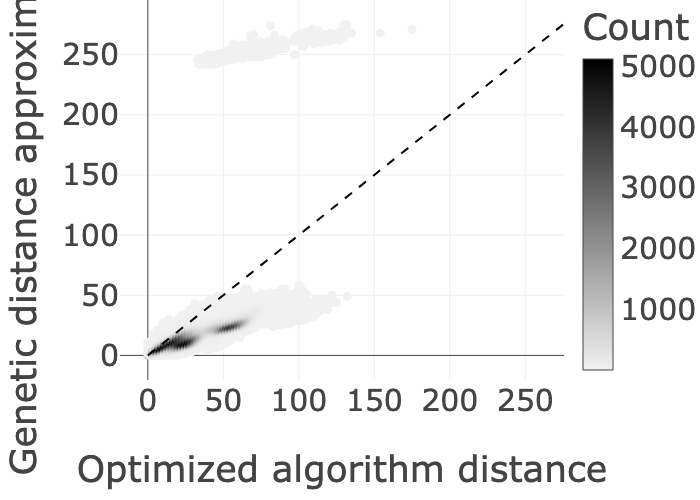

In [18]:
gentrain_flatten = distance_matrix.flatten()
approximated_flatten = observed_matrix.flatten()
data = pd.DataFrame({
    'gentrain': gentrain_flatten,
    'optimized': approximated_flatten
})


data = data.groupby(['gentrain', 'optimized']).size().reset_index(name='count')

fig = px.scatter(data, x='gentrain', y='optimized', color='count', color_continuous_scale=[[0, "#f1f1f1"], [1, "#000000"]], labels={'count': 'Count'})

fig.add_shape(
    type='line',
    x0=min(gentrain_flatten.min(), approximated_flatten.min()),
    y0=min(gentrain_flatten.min(), approximated_flatten.min()),
    x1=max(gentrain_flatten.max(), approximated_flatten.max()),
    y1=max(gentrain_flatten.max(), approximated_flatten.max()),
    line=dict(color='black', width=2, dash='dash'),
    name='y = x',
)
fig.update_layout(width=1000, height=1000,template="presentation",font=dict(size=30),  xaxis=dict(
        title=dict(
              text='Optimized algorithm distance',
            standoff=40
        ),
        tickangle=0
    ),
    margin=dict(l=120,r=0,t=0,b=120),
    yaxis=dict(
        title=dict(
            text='Genetic distance approximation',
            standoff=40
        ),
        tickangle=0
    ),)
fig.show()
fig.write_image("figures/approximation_offset_due_202203.svg", width=1000, height=1000)